In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage


In [15]:
f1 = h5py.File('./datasets/train_catvnoncat.h5', 'r')
f2 = h5py.File('./datasets/test_catvnoncat.h5', 'r')
print f1.keys()
print f2.keys()

[u'list_classes', u'train_set_x', u'train_set_y']
[u'list_classes', u'test_set_x', u'test_set_y']


In [23]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y = f1['train_set_x'], f1['train_set_y'], f2['test_set_x'], f2['test_set_y']

In [34]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
assert(train_set_x_orig.shape[1] == train_set_x_orig.shape[2])
assert(test_set_x_orig.shape[1] == test_set_x_orig.shape[2])
num_px = train_set_x_orig.shape[1]
print 'Number of training examples : ', m_train
print 'Number of test examples : ', m_test
print 'Height/Width of a training image : ', num_px
print 'Shape of train_set_x_orig : ', train_set_x_orig.shape
print 'Shape of train_set_y : ', train_set_y.shape
print 'Shape of test_set_x_orig : ', test_set_x_orig.shape
print 'Shape of test_set_y : ', test_set_y.shape

Number of training examples :  209
Number of test examples :  50
Height/Width of a training image :  64
Shape of train_set_x_orig :  (209, 64, 64, 3)
Shape of train_set_y :  (209,)
Shape of test_set_x_orig :  (50, 64, 64, 3)
Shape of test_set_y :  (50,)


In [40]:
train_set_x = np.array(train_set_x_orig).reshape((m_train, num_px*num_px*3)).T/255.0
train_set_y = np.array(train_set_y).reshape((m_train, 1)).T
test_set_x = np.array(test_set_x_orig).reshape((m_test, num_px*num_px*3)).T/255.0
test_set_y = np.array(test_set_y).reshape(m_test, 1).T
print 'Shape of train_set x and y : ', train_set_x.shape, train_set_y.shape
print 'Shape of test_set x and y : ', test_set_x.shape, test_set_y.shape

Shape of train_set x and y :  (12288, 209) (1, 209)
Shape of test_set x and y :  (12288, 50) (1, 50)


In [75]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [76]:
print 'sigmoid([0, 2]) : ', sigmoid(np.array([0, 2]))

sigmoid([0, 2]) :  [ 0.5         0.88079708]


In [106]:
def random_initializer(dim_input, dim_output):
    w = np.random.randn(dim_input, dim_output)*0.01
    b = np.zeros((1, dim_output))
    return w, b

w, b = random_initializer(2, 1)
print 'w = ', str(w)
print 'b = ', str(b)

w =  [[ 0.00303238]
 [-0.00810277]]
b =  [[ 0.]]


In [122]:
def propagate(w, b, X, Y):
    # Forward
    m = X.shape[1]
    #print 'm : ', m
    z = np.dot(w.T, X) + b    # X is dim_input by m, w is dim_input by dim_output, z should be dim_out by m
    #print 'z : ', z.shape
    A = sigmoid(z)
    #print 'A : ', A
    cost = -1.0 / m * np.sum(Y*np.log(A) + (1-Y)*np.log(1-A))
    #cost = -1 / m * np.sum(Y*np.log(A) + (1-Y)*np.log(1-A))    # BUG: cost is a float, so 1.0 rather than 1
                                                                # (not knowing why output of using 1.0 and 1 is different)
    #print 'cost : ', cost
    
    # Backward
    dz = A - Y    # dz is num_out by m
    #dw = 1.0 / m * np.dot(dz, A.T)    # BUG: dw should use dz*X.T because X = A[l-1] while A here is actually A[l]
    dw = (1.0 / m) * np.dot(dz, X.T).T
    #print 'dw : ', dw
    db = (1.0 / m) * np.sum(dz, axis=1, keepdims=True)
    #print 'db : ', db
    
    assert(w.shape == dw.shape)
    return A, dw, db, cost

A, dw, db, cost = propagate(np.array([[1.], [2.]]), 2., np.array([[1., 2., -1.], [3., 4., -3.2]]), np.array([[1, 0, 1]]))
print 'Output A[l] : ', A, '\nGradients dw[l] and db[l] : ', dw, ' and ', db, '\nCost : ', cost

Output A[l] :  [[ 0.99987661  0.99999386  0.00449627]] 
Gradients dw[l] and db[l] :  [[ 0.99845601]
 [ 2.39507239]]  and  [[ 0.00145558]] 
Cost :  5.80154531939


In [149]:
def optimize(w, b, X, Y, learning_rate, iter_num, print_cost=False):
    costs = []
    for index in range(iter_num):
        A, dw, db, cost = propagate(w, b, X, Y)
        w = w - learning_rate * dw
        b = b - learning_rate * db
        if (index+1) % 100 == 0:
            costs.append(cost)
            if print_cost:
                print 'Cost after iteration', (index+1), ': ', cost
                #print 'w = ', w, '\nb = ', b, '\ndw = ', dw, '\ndb = ', db, '\ncost = ', cost
    params = {'w': w,
              'b': b}
    grads = {'dw': dw,
             'db': db}
    return params, grads, costs
w = np.array([[1.0], [2.0]])
b = 2.0
X = np.array([[1., 2., -1.], [3., 4., -3.2]])
Y = np.array([[1, 0, 1]])
params, grads, costs = optimize(w, b, X, Y, learning_rate=0.009, iter_num=100, print_cost=False)
print 'costs are :', costs

costs are : [1.0784313398164707]


In [91]:
def predict(w, b, X):
    m = X.shape[1]
    Z = np.dot(w.T, X) + b
    Y_prediction = sigmoid(Z)
    assert(Y_prediction.shape == (1, m))
    #print Y_prediction[0]
    for index in range(m):
        if Y_prediction[0, index] <= 0.5: Y_prediction[0, index] = 0.0
        else: Y_prediction[0, index] = 1.0
        
    return Y_prediction

w = np.array([[0.1124579], [0.23106775]])
b = -0.3
X = np.array([[1.0, -1.1, -3.2], [1.2, 2.0, 0.1]])
print 'predictions = ', str(predict(w, b, X))

predictions =  [[ 1.  1.  0.]]


In [133]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.02, iter_num=2000, print_cost=False):
    m = X_train.shape[1]
    n = X_test.shape[1]
    w, b = random_initializer(X_train.shape[0], 1)
    #print 'w.shape = ', w.shape
    #print 'b.shape = ', b.shape
    params, grads, costs = optimize(w, b, X_train, Y_train, learning_rate, iter_num, print_cost)
    
    Y_prediction_test = predict(params['w'], params['b'], X_test)
    Y_prediction_train = predict(params['w'], params['b'], X_train)
    
    print 'Train accuracy: ', 1.0 - np.mean(np.abs(Y_prediction_train - Y_train))
    print 'Test accuracy: ', 1.0 - np.mean(np.abs(Y_prediction_test - Y_test))
    
    params = {'costs': costs,
              'Y_prediction_test': Y_prediction_test,
              'Y_prediction_train': Y_prediction_train,
              'w': params['w'],
              'b': params['b'],
              'learning_rate': learning_rate,
              'iter_num': iter_num
    }
    return params

d = model(train_set_x, train_set_y, test_set_x, test_set_y, learning_rate = 0.005, iter_num = 2000, print_cost=True)

Cost after iteration 100 :  0.635077379459
Cost after iteration 200 :  0.479087209638
Cost after iteration 300 :  0.374795762674
Cost after iteration 400 :  0.331267377013
Cost after iteration 500 :  0.30307390937
Cost after iteration 600 :  0.279674660726
Cost after iteration 700 :  0.259830228747
Cost after iteration 800 :  0.242722117822
Cost after iteration 900 :  0.227780339133
Cost after iteration 1000 :  0.214592093466
Cost after iteration 1100 :  0.202849063968
Cost after iteration 1200 :  0.192315122164
Cost after iteration 1300 :  0.182805597195
Cost after iteration 1400 :  0.174173459305
Cost after iteration 1500 :  0.166299824258
Cost after iteration 1600 :  0.159087257958
Cost after iteration 1700 :  0.152454951289
Cost after iteration 1800 :  0.146335175864
Cost after iteration 1900 :  0.140670635986
Cost after iteration 2000 :  0.135412459377
Train accuracy:  0.99043062201
Test accuracy:  0.7


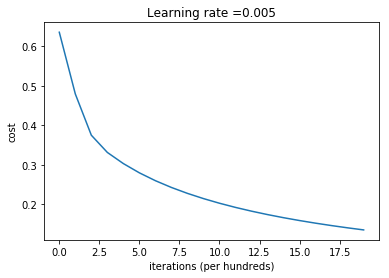

In [141]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

learning rate is: 0.01
Train accuracy:  0.995215311005
Test accuracy:  0.72

-------------------------------------------------------

learning rate is: 0.001
Train accuracy:  0.88995215311
Test accuracy:  0.66

-------------------------------------------------------

learning rate is: 0.005
Train accuracy:  0.976076555024
Test accuracy:  0.72

-------------------------------------------------------

learning rate is: 0.0001
Train accuracy:  0.684210526316
Test accuracy:  0.38

-------------------------------------------------------



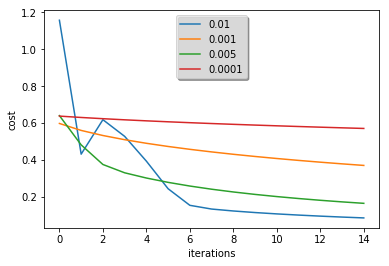

In [151]:
learning_rates = [0.01, 0.001, 0.005, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, learning_rate = i, iter_num = 1500, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

plt.ylabel('cost')
plt.xlabel('iterations')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]['costs']), label= str(models[str(i)]['learning_rate']))

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()